### 1-2,图片数据建模流程范例

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, datasets

In [7]:
BATCH_SIZE = 100 
def load_image(img_path, size = (32,32)):
    label = tf.constant(1,tf.int8) if tf.strings.regex_full_match(img_path,".*/automobile/.*") \
            else tf.constant(0,tf.int8)
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img) #注意此处为jpeg格式
    img = tf.image.resize(img, size)/255.0
    return (img, label)

In [8]:
#使用并行化预处理num_parallel_calls 和预存数据prefetch来提升性能
ds_train = tf.data.Dataset.list_files("../data/cifar2/train/*/*.jpg") \
           .map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
           .shuffle(buffer_size = 1000).batch(BATCH_SIZE) \
           .prefetch(tf.data.experimental.AUTOTUNE)  

ds_test = tf.data.Dataset.list_files("../data/cifar2/test/*/*.jpg") \
           .map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
           .batch(BATCH_SIZE) \
           .prefetch(tf.data.experimental.AUTOTUNE)

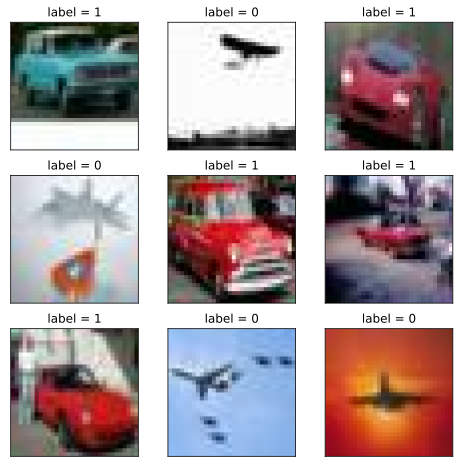

In [13]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

#查看部分样本
from matplotlib import pyplot as plt 

plt.figure(figsize=(8,8)) 
for i,(img,label) in enumerate(ds_train.unbatch().take(9)):
    ax=plt.subplot(3, 3, i+1)
    ax.imshow(img.numpy())
    ax.set_title("label = %d"%label)
    ax.set_xticks([])
    ax.set_yticks([]) 
plt.show()

In [14]:
# build model 
tf.keras.backend.clear_session()  # 清空会话
inputs = layers.Input(shape=(32, 32, 3))
x = layers.Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)  # 30*30
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=2)(x)  # 15*15
x = layers.Conv2D(64, kernel_size=(3, 3), activation='relu')(x)  # 13 * 13
x = layers.Conv2D(64, kernel_size=(3, 3), strides=2, activation='relu')(x)  # 6x6
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D()(x)  # 3*3
x = layers.Flatten()(x)   # 64 * 3 * 3 
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = models.Model(inputs, outputs)
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 30, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 6, 64)          36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 6, 6, 64)          256   

In [16]:
# compile model
import datetime
logdir = "../data/keras_model/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorbord_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

loss = tf.keras.losses.binary_crossentropy
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
metrics = ['AUC']

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)


In [17]:
# train model
history = model.fit(
    ds_train, 
    epochs=10, 
    validation_data=ds_test, 
    callbacks=[tensorbord_callback],
    workers=4)

Epoch 1/10
100/100 [==============================] - 22s 224ms/step - loss: 0.5067 - AUC: 0.8662 - val_loss: 0.0000e+00 - val_AUC: 0.0000e+00
Epoch 2/10
100/100 [==============================] - 19s 191ms/step - loss: 0.3048 - AUC: 0.9445 - val_loss: 0.9193 - val_AUC: 0.9108
Epoch 3/10
100/100 [==============================] - 21s 212ms/step - loss: 0.2447 - AUC: 0.9638 - val_loss: 0.2447 - val_AUC: 0.9652
Epoch 4/10
100/100 [==============================] - 25s 253ms/step - loss: 0.1925 - AUC: 0.9776 - val_loss: 0.3370 - val_AUC: 0.9637
Epoch 5/10
100/100 [==============================] - 20s 197ms/step - loss: 0.1631 - AUC: 0.9833 - val_loss: 0.1819 - val_AUC: 0.9799
Epoch 6/10
100/100 [==============================] - 19s 192ms/step - loss: 0.1448 - AUC: 0.9867 - val_loss: 0.1669 - val_AUC: 0.9840
Epoch 7/10
100/100 [==============================] - 19s 188ms/step - loss: 0.1234 - AUC: 0.9901 - val_loss: 0.2164 - val_AUC: 0.9780
Epoch 8/10
100/100 [===========================

In [18]:
#%load_ext tensorboard
#%tensorboard --logdir ../data/keras_model
from tensorboard import notebook
notebook.list()

No known TensorBoard instances running.


In [21]:
#在tensorboard中查看模型
notebook.start("--logdir ../data/keras_model")

Reusing TensorBoard on port 6006 (pid 99825), started 0:08:54 ago. (Use '!kill 99825' to kill it.)

In [20]:
import pandas as pd 
dfhistory = pd.DataFrame(history.history)
dfhistory.index = range(1,len(dfhistory) + 1)
dfhistory.index.name = 'epoch'

dfhistory

,loss,AUC,val_loss,val_AUC
epoch,,,,
1,0.506732,0.866209,0.807099,0.884340
2,0.304228,0.944482,0.919308,0.910843
3,0.244225,0.963810,0.244659,0.965222
4,0.192521,0.977626,0.336950,0.963672
5,0.163616,0.983286,0.181868,0.979931
6,0.145079,0.986685,0.166916,0.983987
7,0.123366,0.990143,0.216429,0.978010
8,0.105943,0.992623,0.191867,0.983118
9,0.095324,0.993957,0.181532,0.984582


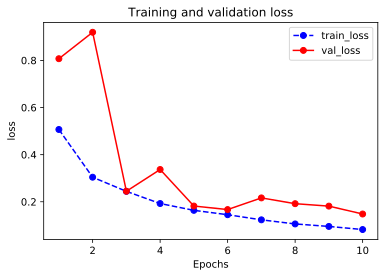

In [22]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()
    
plot_metric(history, "loss")

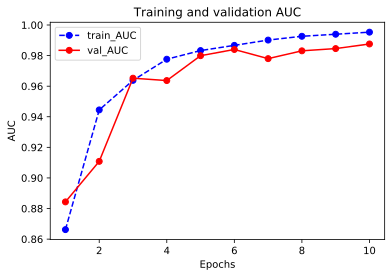

In [23]:
plot_metric(history, "AUC")

In [24]:
#可以使用evaluate对数据进行评估
val_loss,val_accuracy = model.evaluate(ds_test,workers=4)
print(val_loss,val_accuracy)

20/20 [==============================] - 2s 82ms/step - loss: 0.1480 - AUC: 0.9876
0.14803510680794715 0.9875976


In [25]:
model.predict(ds_test)

array([[1.6003847e-05],
       [8.8251579e-01],
       [9.9197686e-01],
       ...,
       [1.0000000e+00],
       [9.9801326e-01],
       [3.6260572e-03]], dtype=float32)

In [26]:
for x,y in ds_test.take(1):
    print(model.predict_on_batch(x[0:20]))

tf.Tensor(
[[0.0000000e+00]
 [6.6161156e-06]
 [0.0000000e+00]
 [9.9999976e-01]
 [5.9604645e-08]
 [8.2723784e-01]
 [9.9996424e-01]
 [1.3817605e-01]
 [9.9999964e-01]
 [2.0623207e-05]
 [9.1584492e-01]
 [2.2953749e-04]
 [9.9994129e-01]
 [9.9197686e-01]
 [9.9995804e-01]
 [9.9999964e-01]
 [9.9869591e-01]
 [1.2312327e-05]
 [9.9910480e-01]
 [9.9995768e-01]], shape=(20, 1), dtype=float32)


In [27]:
for x, y in ds_test.take(1):
    print(len(x))

100
